In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Question 1

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

#### a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

In [2]:
data = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

Let's first look at the distribution of our order_amount feature.

In [4]:
data['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

## Initial Hypothesis

Looking at our statistics above, there are three values that I find to be very interesting:
1. The mean cost is exceptionally high (e.g: It is approximately 3145.128000)
2. The standard deviation is very high as well.
3. I am surprised by seeing the max order value being 704,000. This could possibly be a bulk order.

Looking at the three metrics above, I can then create a hypothesis as follows:
* The Average Order Value (AOV) is coming from the mean of the order amount column which is around ~3145.13.
* With a very high standard deviation, this means that the values vary by roughly 41,282.54 from the mean value, which clearly shows that mean is not a useful metric to take under consideration.
* Observing our max value, it is much higher than all of the other values. Because of this, I could estimate that there are many high-value outliers which are causing the mean to be extremely large.

## Plotting Distribution

Based on our hypothesis above, we can then take a look at the distribution and possibly find our outliers along the way, using a boxplot!

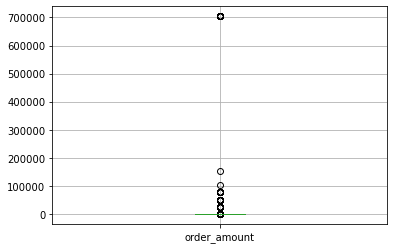

In [12]:
data.boxplot('order_amount')

From the boxplot above, we can see that there is a substantial amount of outliers present around the 700,000 `order_amount` value. One method we can use to view our outliers is to view a table that is sorted in ascending order of order values, and check out the number of data points per value.

In [19]:
data_points = data.groupby(['order_amount']).size()
outlier_values = data_points.reset_index(name='num_data_points').sort_values(by='order_amount', ascending = False)

In [20]:
outlier_values.head(20)

,order_amount,num_data_points
257,704000,17
256,154350,1
255,102900,1
254,77175,9
253,51450,16
252,25725,19
251,1760,1
250,1408,2
249,1086,1
248,1064,1


We now have a good table to to see the spread of our outliers! It is strange to see that our high data points such as (704000, 77175, 51450, 25725) occur so many times - this could be a reason for our large mean order value!

Now, let's take a look at more details of these high ordered values to see how these items are being bought.

In [24]:
high_orders = data.loc[data['order_amount'].isin([704000, 77175, 51450, 25725])] 

In [25]:
high_orders.sort_values(by='order_amount', ascending = False)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00
4056,4057,42,607,704000,2000,credit_card,2017-03-28 4:00:00
2969,2970,42,607,704000,2000,credit_card,2017-03-28 4:00:00
...,...,...,...,...,...,...,...
1204,1205,78,970,25725,1,credit_card,2017-03-17 22:32:21
1193,1194,78,944,25725,1,debit,2017-03-16 16:38:26
1056,1057,78,800,25725,1,debit,2017-03-15 10:16:45
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57


Here, I found something that I was intrigued by. If you look at the time at which the 4 orders with amount value of 704,000 were placed, they seemed to have been placed at the same time every 7-8 days between the same user and store with the same number of total items = 2000. This looks like a classic case of wholesale/bulk orders because a general order of shoes would not cost that much money. The 5th row seems to be a duplicate of the 4th row, causing an unexpectedly high increase in the overall statistics. The order amounts for data points 51,460 and 25,725 appear to be also similar. Additionally, it looks like that the resutant 51,450 order point is just the double order of 25,725 valued order. This is my hypothesis because these orders come from the same store of `shop_id` = 78. 

Statistically speaking, there is one metric which is not affected that much by the outliers which is the median of the data. As such, we could look into the median distribution and evaluate our results. We could look at a median with a range of +/- 2.

In [36]:
IQR = data['order_amount'].quantile(.75) - data['order_amount'].quantile(.25)

In [41]:
filtered_data = data[(data['order_amount'] < data['order_amount'].quantile(.5) + IQR*2) & (data['order_amount'] > data['order_amount'].quantile(.5) - IQR*2)]

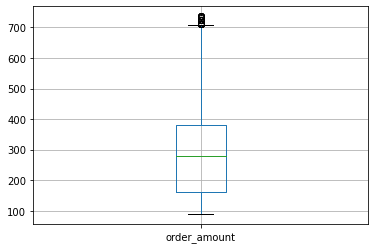

In [42]:
filtered_data.boxplot('order_amount')

Looking at the new distribution, we can still see a few outliers at the top of the chart, but the median and mean are far more clear with the new values represented, and they make more sense to our use case. We can try scaling it down a little more to about +/- 1.75.

In [43]:
filtered_data = data[(data['order_amount'] < data['order_amount'].quantile(.5) + IQR*1.75) & (data['order_amount'] > data['order_amount'].quantile(.5) - IQR*1.75)]

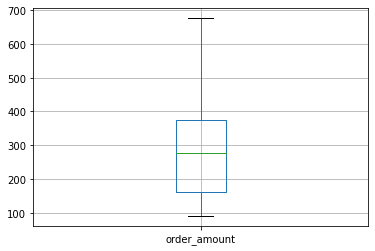

In [44]:
filtered_data.boxplot('order_amount')

There we go! We have a cleaner distribution and we should use this filtered data (`filtered_data`) as a more accurate dataset for shopper and buyer analysis going forward.

#### b. What metric would you report for this dataset?

Upon observing our boxplot above based on the newly filtered dataset, I would choose to study the median of the data because it is more accurately represented than the mean (as the effect on outliers is much lower). As a result, I would use the `median` as a reported metric for this data.

#### c. What is its value?

We can observe the value of our median from the descriptive statistics given below:

In [45]:
filtered_data.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4793.000000,4793.000000,4793.000000,4793.000000,4793.000000
mean,2496.841435,49.799082,850.261840,288.033382,1.924890
std,1443.869341,29.119506,86.878953,137.024626,0.893185
min,1.000000,1.000000,700.000000,90.000000,1.000000
25%,1243.000000,24.000000,776.000000,162.000000,1.000000
50%,2497.000000,50.000000,851.000000,276.000000,2.000000
75%,3748.000000,74.000000,926.000000,374.000000,2.000000
max,5000.000000,100.000000,999.000000,676.000000,5.000000


Looking at the `50%` row and the `order_amount` column, we can report our median metric value as *`$276.00`*

We can also see the large decrease in values of the mean and standard devaiation which looks more reasonable now.

Thank you for taking the time to read my analysis and I hope you found it to be intriguing!

----------------------------------------------------

# Question 2

For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

#### a. How many orders were shipped by Speedy Express in total?

I did an inner join of the Orders and Shippers tables on the ShipperID column.

```SQL
SELECT COUNT(*) AS num_orders
FROM Orders o JOIN Shippers s ON s.ShipperID = o.ShipperID
WHERE s.ShipperName = 'Speedy Express'
```
The result came out to be `54` orders.

#### b. What is the last name of the employee with the most orders?

```SQL
SELECT e.LastName, COUNT(*) AS num_orders
FROM Employees e JOIN Orders o ON e.EmployeeID = o.EmployeeID
GROUP BY e.LastName
ORDER BY num_orders DESC
LIMIT 1;
```

The last name of the employee is `Peacock` with `40` orders.

#### c. What product was ordered the most by customers in Germany?

```SQL
SELECT p.ProductID, p.productName, SUM(od.Quantity) AS total_quantity
FROM OrderDetails od JOIN Orders o ON o.OrderID = od.orderID
JOIN Products p ON od.productID = p.productID
JOIN Customers c ON c.CustomerID = o.CustomerID
WHERE c.Country = 'Germany'
GROUP BY p.productID
ORDER BY total_quantity DESC
LIMIT 1;
```

The product was found to be `Boston Crab Meat` with total orders = `160`.